In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv("./AB_US_2023.csv")
df.shape

C:\Users\NITISH KUMAR\AppData\Local\Temp\ipykernel_8832\1507792788.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./AB_US_2023.csv")


(232147, 18)

In [3]:
df.describe().round(2)

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,2.321470e+05,2.321470e+05,232147.00,232147.00,232147.00,232147.00,232147.00,183062.00,232147.00,232147.00,232147.00
mean,2.584580e+17,1.582248e+08,36.61,-98.30,259.47,13.50,40.92,1.64,29.88,180.99,11.69
std,3.465985e+17,1.587164e+08,5.13,19.71,1024.65,27.92,80.65,1.91,106.01,134.72,20.60
min,6.000000e+00,2.300000e+01,25.96,-123.09,0.00,1.00,0.00,0.01,1.00,0.00,0.00
25%,2.638896e+07,2.299242e+07,33.98,-118.32,91.00,2.00,1.00,0.31,1.00,52.00,0.00
50%,4.896307e+07,1.005783e+08,36.19,-97.73,149.00,3.00,9.00,1.00,2.00,175.00,3.00
75%,6.633014e+17,2.686930e+08,40.72,-77.03,250.00,30.00,43.00,2.42,10.00,321.00,16.00
max,8.581014e+17,5.069384e+08,47.73,-71.00,100000.00,1250.00,3091.00,101.42,1003.00,365.00,1314.00


In [4]:
df.loc[df['price']==0, 'name'].values

array(['Hotel Emblem San Francisco', 'Hotel Triton San Francisco',
       'Bedroom, bath and garden', 'Capital View Hostel',
       'citizenM Washington DC Capitol',
       'The Drifter / 21+ / Boutique Hotel', 'Federal City Inn & Suites',
       'Hotel Royal', 'Melrose Suites', 'Historic Streetcar Inn',
       'Chateau Hotel', 'Audubon Cottages', 'The Old No. 77 Hotel',
       'Glendale Express', 'LA Best Inn', 'Test Hotel',
       'L’Ermitage Beverly Hills', 'Nite Inn at Universal City',
       'Beverly Hills Plaza Hotel & Spa', 'Shore Hotel',
       'The Prospect Hollywood', 'Gold-Diggers Hotel',
       'Lexen Hotel North Hollywood', 'The LINE Hotel', 'Hotel Erwin',
       'El Patio Inn', 'Mondrian Los Angeles',
       'The Hoxton, Williamsburg - Cosy Room',
       'The James New York - NoMad', 'Gardens Suites Hotel by Affinia',
       'Mint House At 70 Pine', 'Leon Hotel LES', 'Carvi Hotel NYC',
       'Hotel Five44', 'Opera House Hotel', 'The Wall Street Inn',
       'Sister City 

In [5]:
df.loc[df['name'].str.lower().str.contains('shared room').astype(bool), ['price']].describe()

,price
count,376.000000
mean,54.957447
std,89.809299
min,10.000000
25%,30.000000
50%,40.000000
75%,45.000000
max,950.000000


In [6]:
feats = [
    'latitude', 'longitude', 'minimum_nights',
    'number_of_reviews', 'reviews_per_month',
    'calculated_host_listings_count', 'availability_365'
]
target = 'price'
model_data = df.dropna(subset=[target]+feats)
model_data.shape

(183062, 18)

In [7]:
model_data.loc[:, feats+[target]].sample(5)

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price
83376,40.75070,-73.89537,30,2,0.05,207,0,30
103907,40.73307,-73.99005,2,22,5.45,1,1,380
26853,34.07919,-118.20294,30,2,0.61,1,151,37
186731,47.61849,-122.32456,1,110,6.41,4,235,106
93383,40.83221,-73.90007,1,89,4.85,1,339,111


In [8]:
feats

['latitude',
 'longitude',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

In [9]:
target

'price'

In [10]:
df.columns.values

array(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'city'], dtype=object)

In [11]:
x = df.dtypes
x[x!='object'].index

Index(['id', 'host_id', 'latitude', 'longitude', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm'],
      dtype='object')

In [12]:
folds = 5
kf = KFold(folds, shuffle=True)
s1 = pd.Series()
s2 = pd.Series()

for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  
  model = LinearRegression()
  model.fit(train_data.loc[:, feats], train_data[target])
  _s1 = pd.Series(model.predict(test_data.loc[:, feats]), index=test_data.index)

  model = RandomForestRegressor()
  model.fit(train_data.loc[:, feats], train_data[target])
  _s2 = pd.Series(model.predict(test_data.loc[:, feats]), index=test_data.index)

  s1 = pd.concat([s1,_s1])
  s2 = pd.concat([s2,_s2])

model_data[f'{target}_lr'] = s1
model_data[f'{target}_rf'] = s2

C:\Users\NITISH KUMAR\AppData\Local\Temp\ipykernel_8832\2119999769.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data[f'{target}_lr'] = s1
C:\Users\NITISH KUMAR\AppData\Local\Temp\ipykernel_8832\2119999769.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data[f'{target}_rf'] = s2


In [13]:
model_data[target].quantile([.07,.97])

0.07     52.0
0.97    749.0
Name: price, dtype: float64

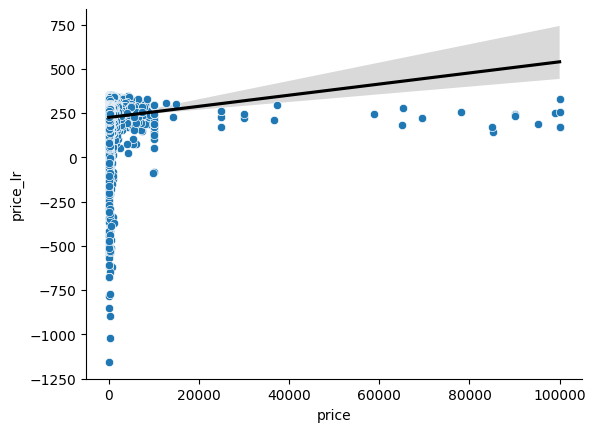

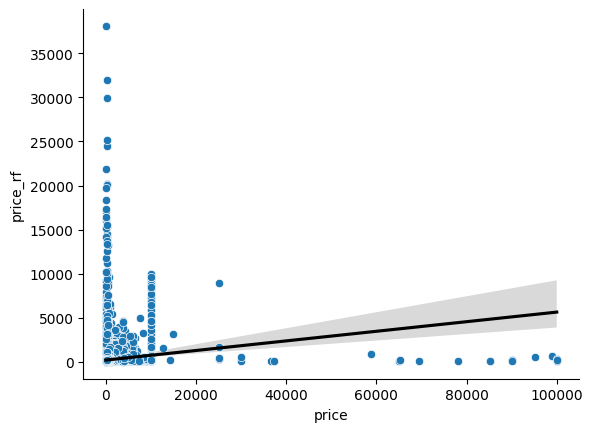

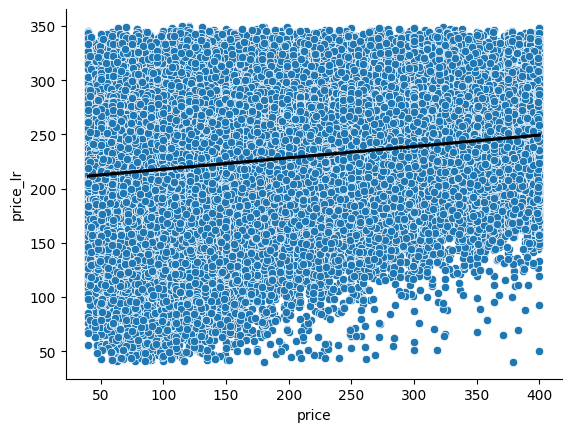

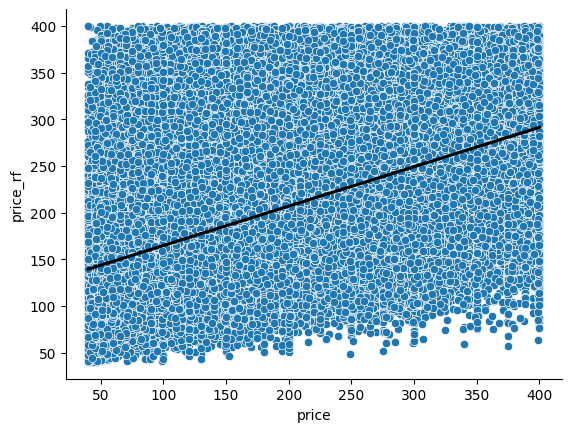

In [14]:
sns.regplot(data=model_data, x=target, y=f'{target}_lr', scatter=False, color='k')
sns.scatterplot(data=model_data, x=target, y=f'{target}_lr')
sns.despine()
plt.show()

sns.regplot(data=model_data, x=target, y=f'{target}_rf', scatter=False, color='k')
sns.scatterplot(data=model_data, x=target, y=f'{target}_rf')
sns.despine()
plt.show()

sns.regplot(data=model_data.loc[(model_data[target].between(40,400)) & (model_data[f"{target}_lr"].between(40,400))], x=target, y=f'{target}_lr', scatter=False, color='k')
sns.scatterplot(data=model_data.loc[(model_data[target].between(40,400)) & (model_data[f"{target}_lr"].between(40,400))], x=target, y=f'{target}_lr')
sns.despine()
plt.show()

sns.regplot(data=model_data.loc[(model_data[target].between(40,400)) & (model_data[f"{target}_rf"].between(40,400))], x=target, y=f'{target}_rf', scatter=False, color='k')
sns.scatterplot(data=model_data.loc[(model_data[target].between(40,400)) & (model_data[f"{target}_rf"].between(40,400))], x=target, y=f'{target}_rf')
sns.despine()
plt.show()